In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import scipy.io as sio
import pandas as pd
from numpy import count_nonzero
import matplotlib.pyplot as plt
import scipy.sparse as ss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import tree
from tabulate import tabulate

In [2]:
data = sio.loadmat('mnist.mat')

Xtrain = data['trainX'][:10000, :].astype(int)
Xtest = data['testX'].astype(int)
ytrain = data['trainY'][0, :10000].astype(int)
ytest = data['testY'][0, :].astype(int)

idx = np.logical_or(np.equal(ytrain, 4), np.equal(ytrain, 9))
Xtrain = Xtrain[idx, :]
ytrain = ytrain[idx]
ytrain[np.equal(ytrain, 4)] = 1
ytrain[np.equal(ytrain, 9)] = -1

idx = np.logical_or(np.equal(ytest, 4), np.equal(ytest, 9))
Xtest = Xtest[idx, :]
ytest = ytest[idx]
ytest[np.equal(ytest, 4)] = 1
ytest[np.equal(ytest, 9)] = -1

sio.savemat('mnist_binary_small.mat', {'Xtrain': Xtrain, 'ytrain': ytrain, 'Xtest': Xtest, 'ytest': ytest})

data = sio.loadmat('mnist_binary_small.mat')

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(1958, 784) (1991, 784) (1958,) (1991,)


## Helper Functions

In [3]:
def get_misclass(y,yhat):
    incorrect = 0
    totalSamples = len(y)
    for i in range(totalSamples):
        if y[i] != yhat[i]:
            incorrect += 1
    return incorrect / totalSamples

def getExponentialLoss(y, yhat):
    return np.sum(np.exp(-y * yhat)) / len(y)


def plot(y, yLabel, title):
    x = list(range(len(y)))
    plt.figure(figsize=(14, 8))
    plt.plot(x, y)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel(yLabel, fontsize=12)
    plt.title(title , fontsize=18)
    plt.show()

## Without AdaBoost

In [4]:
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  splitter='best',
                                  max_depth=1, 
                                  class_weight='balanced')
w = [1/len(Xtrain)]*len(Xtrain)
clf = clf.fit(Xtrain, ytrain, sample_weight = w)

yPredTrain = clf.predict(Xtrain)
yPredTest = clf.predict(Xtest)
results = []
results.append([1,
               get_misclass(ytrain, yPredTrain),
               get_misclass(ytest, yPredTest),
               ])
columns = ['depth',              
            'misclassification rate (train)',
            'misclassification rate (test)',]

pd.set_option("display.max_colwidth",2)
df = pd.DataFrame(results, columns=columns)

print("Train andf test misclassification rates")
print(tabulate(df.set_index('depth'), headers='keys', tablefmt='psql'))

print("\n Train Exponential Loss Value: "+str(getExponentialLoss(ytrain, yPredTrain)))

Train andf test misclassification rates
+---------+----------------------------------+---------------------------------+
|   depth |   misclassification rate (train) |   misclassification rate (test) |
|---------+----------------------------------+---------------------------------|
|       1 |                         0.109806 |                        0.152687 |
+---------+----------------------------------+---------------------------------+

 Train Exponential Loss Value: 0.6259675480492947


## With AdaBoost

In [5]:
def predictAdaboost(X, stumps, stump_weights):
    # Stumps will be of size = (iterations, ) -> For every iteration we get 1 stump
    # Stump weights will be of size = (iterations, ) -> For every iteration we get 1 stump

    allStumpPredictions = []
    for i in range(len(stumps)):
        allStumpPredictions.append((stumps[i].predict(X)))

    weightedStumpPredictions = allStumpPredictions * stump_weights[:, None]
    sumOfWeightedStumpPredictions = weightedStumpPredictions.sum(axis=0)
    finalStumpPrediction = np.sign(sumOfWeightedStumpPredictions)

    return finalStumpPrediction


def getErrorAndAlpha(stumpWeight, stumpPrediction, y):
    error = np.sum(stumpWeight[(stumpPrediction != y)])
    alpha = 1 / 2 * np.log((1 - error) / error)
    return error, alpha


def fitAdaboost(XTrain, yTrain, XTest, yTest, iterations):
    # Total samples
    numberOfSamples = XTrain.shape[0]

    # initialization
    exponentialLossOnlyForTheCurrentStump = np.zeros(shape=iterations)
    exponentialLossConsideringAllStumps = np.zeros(shape=iterations)
    trainMisclassificationRate = np.zeros(shape=iterations)
    testMissclassificationRate = np.zeros(shape=iterations)
    trainMisclassificationRateContinuous = np.zeros(shape=iterations)
    testMissclassificationRateContinuous = np.zeros(shape=iterations)
    weights = np.zeros(shape=(iterations, numberOfSamples))
    stumps = np.zeros(shape=iterations, dtype=object)
    stump_weights = np.zeros(shape=iterations)
    errors = np.zeros(shape=iterations)
    alphas = np.zeros(shape=iterations)

    # initialize weights uniformly
    # Initial weights will be 1/n
    # n -> number of samples
    weights[0] = np.ones(shape=numberOfSamples) / numberOfSamples

    for index in range(iterations):
        # We will create new stump for every iteration
        currentWeights = weights[index]
        stump = tree.DecisionTreeClassifier(criterion='entropy',
                                            splitter='best',
                                            max_depth=1,
                                            max_leaf_nodes=2,
                                            class_weight='balanced')
        stump = stump.fit(XTrain, yTrain, sample_weight=currentWeights)

        # Stump Predictions for Test Set and Train Set
        stumpTrainPrediction = stump.predict(XTrain)
        stumpTestPrediction = stump.predict(XTest)

        # Stump Train and Test Misclassification rates
        trainMisclassificationRate[index] = get_misclass(yTrain, stumpTrainPrediction)
        testMissclassificationRate[index] = get_misclass(yTest, stumpTestPrediction)
        exponentialLossOnlyForTheCurrentStump[index] = getExponentialLoss(stumpTrainPrediction, yTrain)

        error, alpha = getErrorAndAlpha(currentWeights, stumpTrainPrediction, yTrain)

        updatedSampleWeights = currentWeights * np.exp(-alpha * yTrain * stumpTrainPrediction)
        # Normalizing new sample weights
        updatedSampleWeights /= updatedSampleWeights.sum()

        # If not final iteration, update sample weights for t+1
        if index != iterations - 1:
            weights[index + 1] = updatedSampleWeights

        stumps[index] = stump
        stump_weights[index] = alpha
        
        # All the required results for plotting
        cummilative_stump_train_prediction = predictAdaboost(XTrain, stumps[:index + 1], stump_weights[:index + 1])
        cummilative_stump_test_prediction = predictAdaboost(XTest, stumps[:index + 1], stump_weights[:index + 1])

        errors[index] = error
        alphas[index] = alpha
        exponentialLossConsideringAllStumps[index] = getExponentialLoss(cummilative_stump_train_prediction, ytrain)
        trainMisclassificationRateContinuous[index] = get_misclass(yTrain, cummilative_stump_train_prediction)
        testMissclassificationRateContinuous[index] = get_misclass(yTest, cummilative_stump_test_prediction)

    output = [stumps,
              stump_weights,
              exponentialLossOnlyForTheCurrentStump,
              trainMisclassificationRate,
              testMissclassificationRate,
              exponentialLossConsideringAllStumps,
              trainMisclassificationRateContinuous,
              testMissclassificationRateContinuous,
              errors,
              alphas]

    return output

In [6]:
iterations = 100
modelParameters = fitAdaboost(Xtrain, ytrain, Xtest, ytest, iterations)
stumps = modelParameters[0]
stump_weights = modelParameters[1]
exponentialLossOnlyForTheCurrentStump = modelParameters[2]
trainMisclassificationRate = modelParameters[3]
testMissclassificationRate = modelParameters[4]
exponentialLossConsideringAllStumps = modelParameters[5]
trainMisclassificationRateContinuous = modelParameters[6]
testMissclassificationRateContinuous = modelParameters[7]
errors = modelParameters[8]
alphas = modelParameters[9]
yPredTrain = predictAdaboost(Xtrain, stumps, stump_weights)
yPredTest = predictAdaboost(Xtest, stumps, stump_weights)
results = [[get_misclass(ytrain, yPredTrain),
            get_misclass(ytest, yPredTest),
            ]]
columns = ['misclassification rate (train)',
           'misclassification rate (test)', ]

pd.set_option("display.max_colwidth", 2)
df = pd.DataFrame(results, columns=columns)

print("Train andf test misclassification rates after " + str(iterations) + " iterations")
print(tabulate(df, headers='keys', tablefmt='psql'))

print("\n Train Exponential Loss Value after " + str(iterations) + " iterations: " + str(
    getExponentialLoss(ytrain, yPredTrain)))


Train andf test misclassification rates after 100 iterations
+----+----------------------------------+---------------------------------+
|    |   misclassification rate (train) |   misclassification rate (test) |
|----+----------------------------------+---------------------------------|
|  0 |                         0.014811 |                        0.048217 |
+----+----------------------------------+---------------------------------+

 Train Exponential Loss Value after 100 iterations: 0.4026913253549667


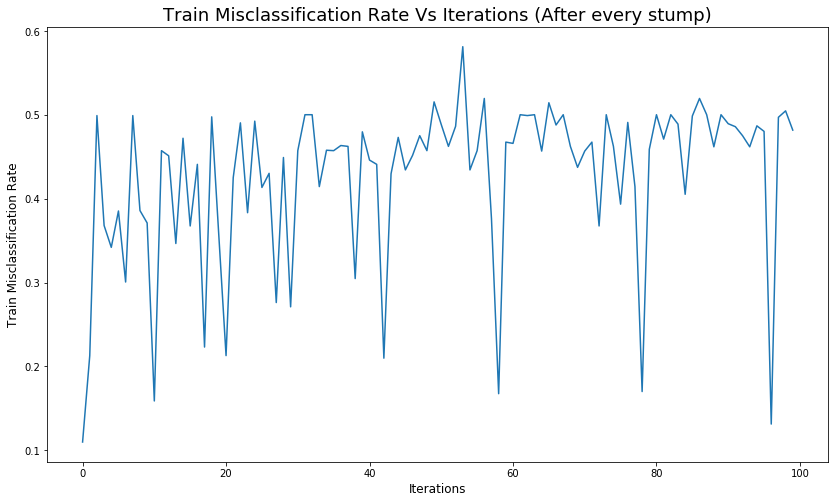

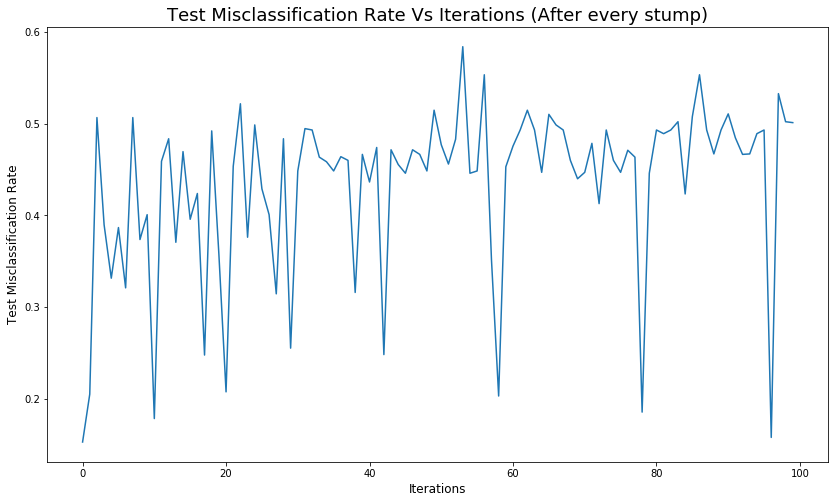

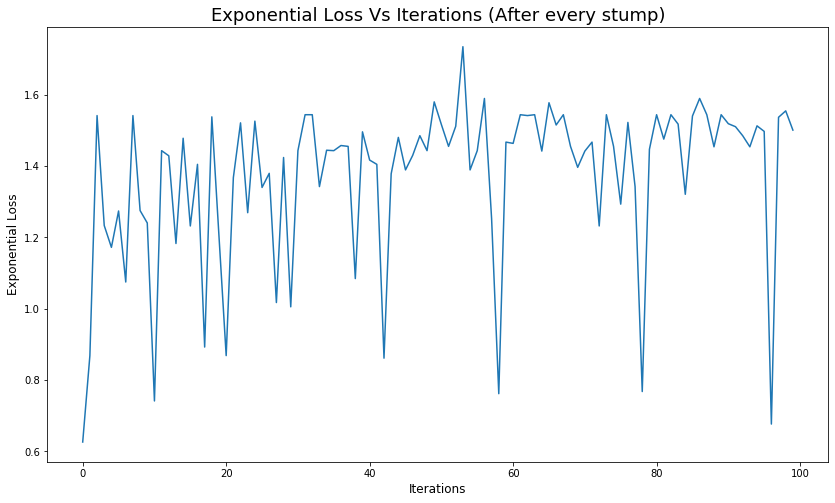

In [7]:
plot(trainMisclassificationRate,'Train Misclassification Rate' ,'Train Misclassification Rate Vs Iterations (After every stump)')
plot(testMissclassificationRate, 'Test Misclassification Rate' ,'Test Misclassification Rate Vs Iterations (After every stump)')
plot(exponentialLossOnlyForTheCurrentStump, 'Exponential Loss' ,'Exponential Loss Vs Iterations (After every stump)')

## Comments

1) Misclassification rate and exponential loss after every stump by itself does not have a great value

by themselves and is quiet evident from the graph as each stump is a weak learner.

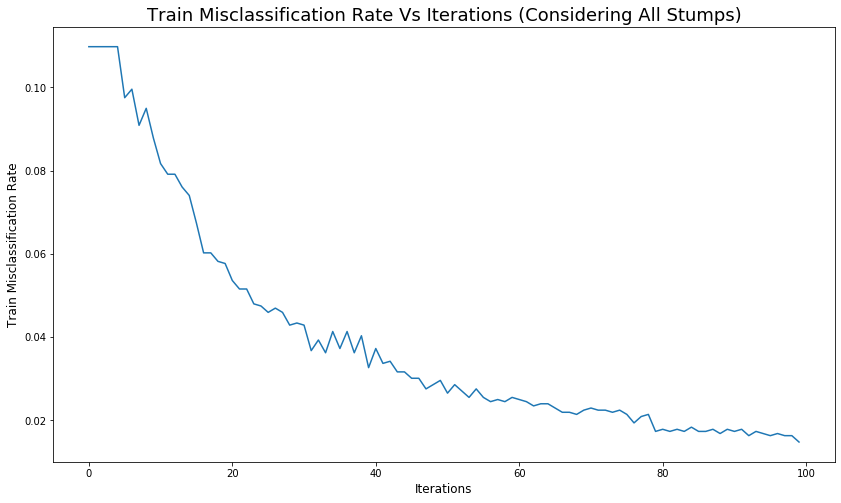

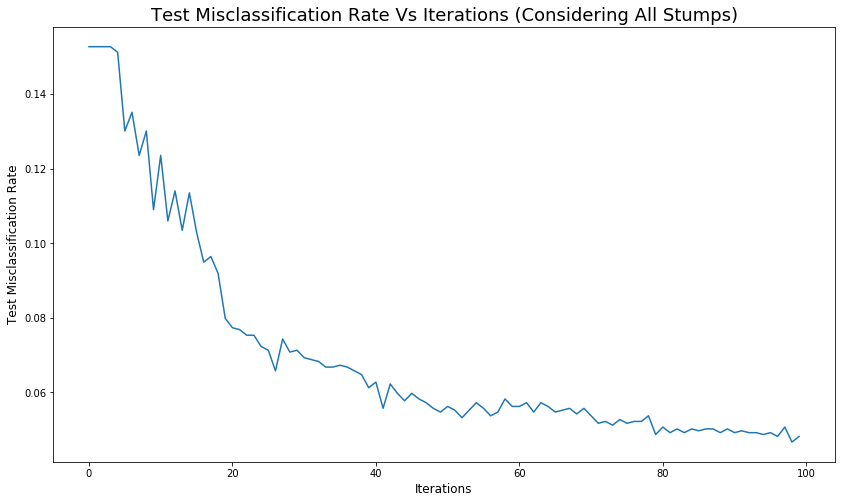

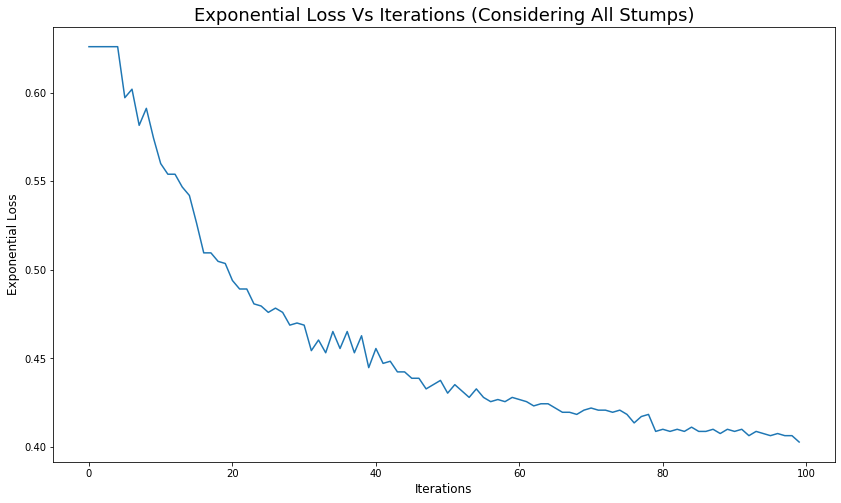

In [8]:
plot(trainMisclassificationRateContinuous, 'Train Misclassification Rate' , 'Train Misclassification Rate Vs Iterations (Considering All Stumps)')
plot(testMissclassificationRateContinuous, 'Test Misclassification Rate'  , 'Test Misclassification Rate Vs Iterations (Considering All Stumps)')
plot(exponentialLossConsideringAllStumps , 'Exponential Loss'             , 'Exponential Loss Vs Iterations (Considering All Stumps)')


## Comments

1) Misclassification rate and exponential loss are reducing  after every iteration and that can be confirmed with the graph as as well.

The difference between the first set of graphs and the latter are:

In the first set, we were computing values only for that stump.

For the second set, we are computing values for all the stumps calculated until then.

## $\epsilon^{(t)}$, $\alpha^{(t)}$ as a function of t

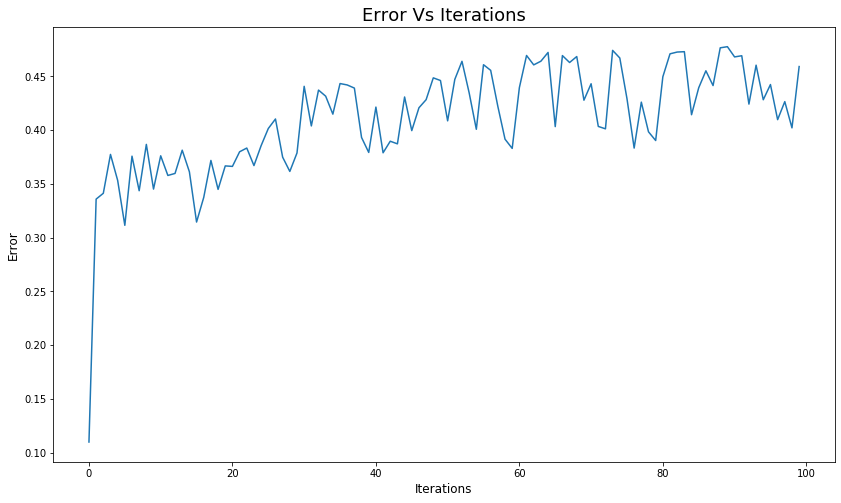

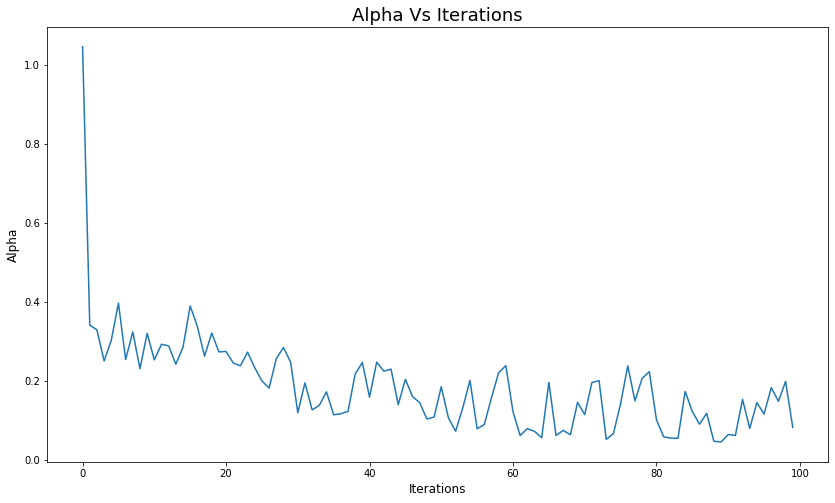

In [9]:
plot(errors , 'Error' , 'Error Vs Iterations')
plot(alphas , 'Alpha' , 'Alpha Vs Iterations')


## Comments

1) Total error takes a value between 0 and 1.

0-> very good stump

1-> very bad stump

2) Alpha,or the amount of say a stump has is inversely proportional to the error.

More, the error, less alpha and vice-versa.

**When total error is small, i.e. if a stump is good then alpha will be a large positive value.**

### Interpretations (in terms of weighted performance):

1) If a stump has a high weight and high alpha value, it's say in the final prediction would be high.

2) If a stump has a low alpha value, it's say would be very less.

3) If error is 0.5 (i.e. just a random guess), it's alpha value would be 0, i.e that stump would mean nothing in the final prediction.
